In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *

# torch._dynamo.config.suppress_errors = True

Load dataset:

In [2]:
data_size = 640_000
data_gen = single_random_ring(N=32)
X, y = data_gen.generate_dataset(data_size=data_size, noise=False, seed=42, device='cpu', test_return=True)

tensor([[0.5333, 0.2667, 0.6364, 0.0253, 0.4591, 0.5354]])


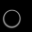

In [3]:
i = np.random.choice(data_size)
X_ = torch.Tensor(X[i].reshape(1, -1))
print(X_)
Image.fromarray((y[i] * 255).astype(np.uint8))

Test generator:

In [10]:
# load generator
generator = bbuffer_DGBaNR(data_gen.n_features, 32, 'tanh')
# generator = torch.compile(generator)

pre_trained_weights = torch.load('../save_data/single_random_ring/Adam_mse_loss_0/bbuffer_DGBaNR_tanh/bbuffer_DGBaNR_tanh_18.pt', map_location=torch.device('cpu'))
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print('Number of parameters:', sum(p.numel() for p in generator.parameters()))

bbuffer_DGBaNR(
  (linear_layers): Sequential(
    (0): Linear(in_features=6, out_features=108, bias=True)
    (1): ReLU()
    (2): Linear(in_features=108, out_features=972, bias=True)
    (3): ReLU()
    (4): Linear(in_features=972, out_features=8192, bias=True)
    (5): ReLU()
  )
  (conv_layers): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (bayes_1): LinearReparameterization()
  (batch_norm_1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bayes_2): LinearReparameterization()
  (batch_norm_2): BatchNorm1d(1024,

0.009681916790125495


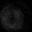

In [12]:
y_pred = generator(X_.clone())[0].detach().numpy().squeeze()
print(((y[i] - y_pred)**2).mean())
Image.fromarray((abs(y_pred) * 255).astype(np.uint8()))

In [13]:
# setting the base feature
n_samples = 1000

# getting the predictions for this feature
pred_rings = np.zeros((n_samples, 32, 32))
with torch.no_grad():
    for j in range(n_samples):
        pred_rings[j] += generator(X_)[0].detach().numpy().squeeze()
pred_ring = pred_rings.sum(axis=0)

# summing the predictions
pred_prob = pred_ring * 255 / pred_ring.max()
true_prob = data_gen.gaussian_from_features(*data_gen.scaler.inverse_transform(X_)[0].tolist()) * 255

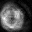

In [14]:
# predicted gaussian ring
Image.fromarray(abs(pred_prob).astype(np.uint8))

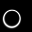

In [15]:
# true gaussian ring
Image.fromarray(true_prob.astype(np.uint8))

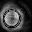

In [16]:
# difference between the rings
Image.fromarray(np.abs(true_prob - pred_prob).astype(np.uint8))

In [17]:
# MSE error
((pred_prob / pred_prob.max() - true_prob / true_prob.max())**2).mean()

0.1036709550764075

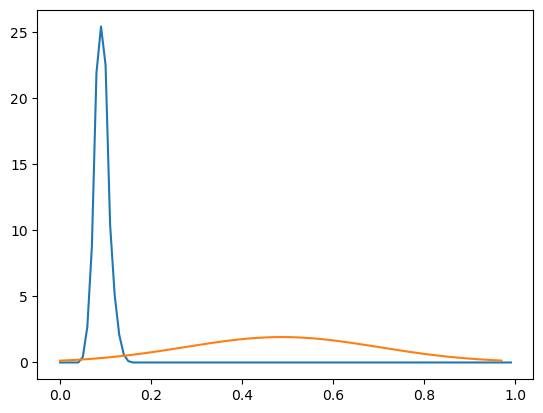

In [19]:
# getting the distribution for one pmt
pmt = (10, 9)
pred = pd.Series(pred_rings[:, pmt[0], pmt[1]])
hist = pd.Series(1, index=pd.cut(pred, np.arange(0, 1.01, 0.01))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * 0.01)

plt.plot(np.arange(0, 1, 0.01), pred_noise)

val = np.arange(0, 2, 0.01) * true_prob[pmt] / (2 * 255)
true_pmt_distr = np.exp(-(val - true_prob[pmt] / (2 * 255))**2 / 0.3**2)
true_pmt_distr /= true_pmt_distr.sum() * 0.01 * true_prob[pmt] / (2 * 255)
plt.plot(val, true_pmt_distr)
plt.show()